In [1]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from flask import Flask, render_template
from sqlalchemy import create_engine
import pandas as pd
import datetime as dt
import numpy as np
import dbinfo
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import pickle 
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

In [66]:
engine = create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(dbinfo.USER, dbinfo.PASSWORD, dbinfo.URI, dbinfo.PORT, dbinfo.DB), echo=True)
df = pd.read_sql("SELECT available_bikes, last_update FROM availability WHERE number = 2;", engine)

df.to_json(orient='records')

OperationalError: (mysql.connector.errors.OperationalError) 1040 (08004): Too many connections
(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [3]:
engine = create_engine("mysql+mysqlconnector://{}:{}@{}:{}/{}".format(dbinfo.USER, dbinfo.PASSWORD, dbinfo.URI, dbinfo.PORT, dbinfo.DB), echo=True)
weather_df = pd.read_sql("SELECT * FROM weather;", 
        engine)
weather_df.to_json(orient='records')

2021-04-08 15:45:54,457 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-04-08 15:45:54,458 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 15:45:54,803 INFO sqlalchemy.engine.base.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-04-08 15:45:54,804 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 15:45:55,431 INFO sqlalchemy.engine.base.Engine SELECT DATABASE()
2021-04-08 15:45:55,432 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 15:45:56,101 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS CHAR(60)) AS anon_1
2021-04-08 15:45:56,103 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 15:45:56,423 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS CHAR(60)) AS anon_1
2021-04-08 15:45:56,424 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 15:45:56,847 INFO sqlalchemy.engine.base.Engine DESCRIBE `SELECT * FROM weather;`
2021-04-08 15:45:56,848 INFO sqlalchemy.engine.base.Engine {}
2021-04-08 15:45:56,953 INFO sql

'[{"time":1614463327000,"temp":7.84,"humidity":81,"main":"Clouds","description":"broken clouds","wind_speed":1.03,"visibility":null,"icon":null},{"time":1614463776000,"temp":7.95,"humidity":81,"main":"Clouds","description":"broken clouds","wind_speed":1.03,"visibility":null,"icon":null},{"time":1614470976000,"temp":7.69,"humidity":87,"main":"Clouds","description":"broken clouds","wind_speed":2.06,"visibility":null,"icon":null},{"time":1614478177000,"temp":6.2,"humidity":93,"main":"Clouds","description":"broken clouds","wind_speed":1.54,"visibility":null,"icon":null},{"time":1614485377000,"temp":4.51,"humidity":87,"main":"Clouds","description":"broken clouds","wind_speed":0.51,"visibility":null,"icon":null},{"time":1614492577000,"temp":3.8,"humidity":100,"main":"Clouds","description":"scattered clouds","wind_speed":1.03,"visibility":null,"icon":null},{"time":1614499778000,"temp":3.21,"humidity":93,"main":"Fog","description":"fog","wind_speed":1.54,"visibility":null,"icon":null},{"time":

In [4]:
#intervals of 30 minutes
threshold_ns = 30 * 60 * 1e9

# compute "interval" to which each update belongs
df['interval'] = pd.to_datetime(np.round(df.last_update.astype(np.int64) / threshold_ns) * threshold_ns)
weather_df['interval'] = pd.to_datetime(np.round(weather_df.time.astype(np.int64) / threshold_ns) * threshold_ns)

In [5]:
#join dataframes together based on interval (inner join)
merged_df = pd.merge(df,weather_df,  how ='inner', on='interval')

In [6]:
#create column for hour and weekday based off of the interval 
merged_df['hour'] = list(map(lambda v : v.hour, merged_df['interval']))
merged_df['weekday'] = list(map(lambda v : v.weekday(), merged_df['interval']))

In [7]:
#dropping all rows between hours of 12AM to 5AM when the stations are closed
#keeping these rows may skew results.
merged_df = merged_df[merged_df['hour'] > 4]


In [8]:
#changing categorical variables from type object to type category
merged_df['main'] = merged_df['main'].astype('category')
merged_df['hour'] = merged_df['hour'].astype('category')
merged_df['weekday'] = merged_df['weekday'].astype('category')

In [9]:
#converting categorical data into dummy or indicator variables 
dummy_columns = ['main','hour','weekday']
for col in dummy_columns:
    dummies = pd.get_dummies(merged_df[col], prefix=col)
    merged_df = pd.concat([merged_df,dummies], axis = 1)


#dropping unused columns
dropped_columns = ['last_update','time','description','icon', 'interval','main','hour','weekday','visibility']
merged_df = merged_df.drop(dropped_columns, axis=1)

In [10]:
#checking for null values
merged_df.isnull().sum()

available_bikes    0
temp               0
humidity           0
wind_speed         0
main_Clear         0
main_Clouds        0
main_Drizzle       0
main_Fog           0
main_Mist          0
main_Rain          0
main_Snow          0
hour_5             0
hour_6             0
hour_7             0
hour_8             0
hour_9             0
hour_10            0
hour_11            0
hour_12            0
hour_13            0
hour_14            0
hour_15            0
hour_16            0
hour_17            0
hour_18            0
hour_19            0
hour_20            0
hour_21            0
hour_22            0
hour_23            0
weekday_0          0
weekday_1          0
weekday_2          0
weekday_3          0
weekday_4          0
weekday_5          0
weekday_6          0
dtype: int64

In [11]:
#creating variables ansd target feature 
x = merged_df.drop('available_bikes',axis=1)
y = merged_df['available_bikes']

In [12]:
#standardising the continuous features before evaluation 
X_stand = x.copy()

scaled = {}

# numerical features
num_cols = ['temp','humidity','wind_speed']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_stand[[i]])
    
    # transform the training data column
    X_stand[i] = scale.transform(X_stand[[i]])
    
    mean,std = scale.mean_, scale.var_
    scaled[i] = [mean,std]

In [13]:
with open('scale_station2.pkl', 'wb') as f: 
    pickle.dump(scaled, f, pickle.HIGHEST_PROTOCOL)

In [14]:
#test-train split 
X_train, X_test, Y_train, Y_test = train_test_split(X_stand, y, test_size=0.3, random_state=0)

# Multiple Linear Rgeression Model 

In [15]:
#creating and fitting the linear model 
regression = linear_model.LinearRegression()
regression.fit(X_train,Y_train)

LinearRegression()

In [16]:
#predicitng from the test set 
y_pred_linear = regression.predict(X_test)

In [17]:
#some evaluation metrics, R2 value is quite low.
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_linear))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_linear))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_linear)))
print('R-square value:', r2_score(Y_test,y_pred_linear))

Mean Absolute Error: 3.1659638611885748
Mean Squared Error: 14.99565968323766
Root Mean Squared Error: 3.8724229731832835
R-square value: 0.09201658155955117


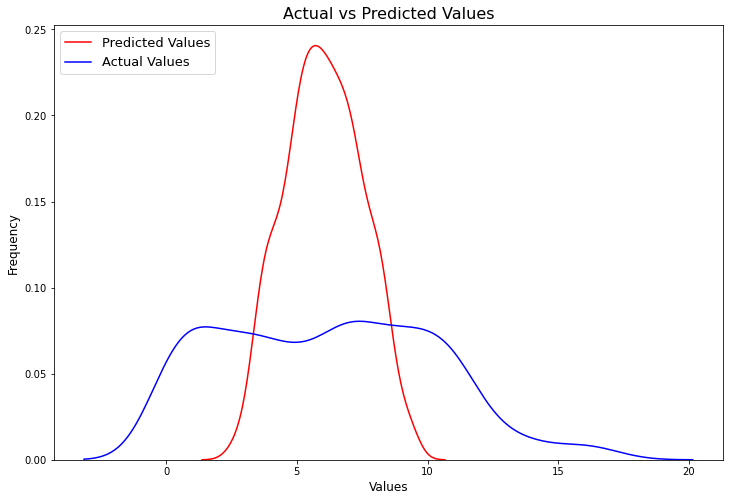

In [18]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.distplot(y_pred_linear, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(Y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)


Judging by these plots it seems that a multiple linear regression model does not fit the data very well. We will try a KNN model as an alternative. 

# KNN Model

scores: [0.5395033860045146, 0.48419864559819414, 0.45598194130925507]


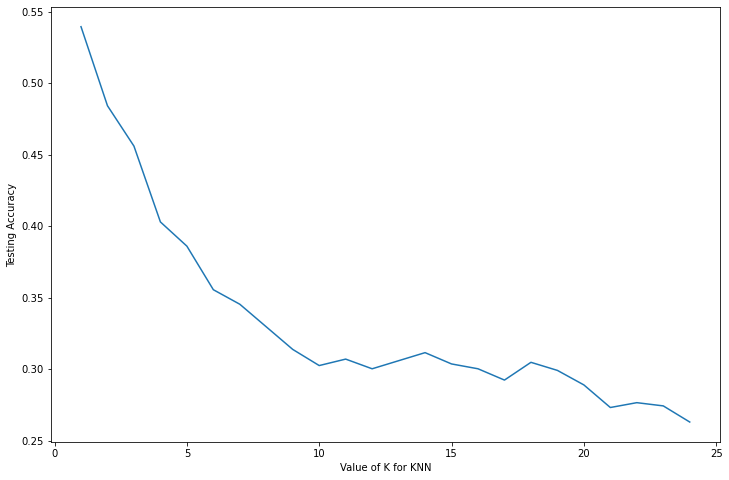

In [51]:
scores = []
for i in range(1,25):
    knnmodel_test = KNeighborsClassifier(n_neighbors=i)
    knnmodel_test.fit(X_train,Y_train)
    y_pred_test = knnmodel_test.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test, y_pred_test)
    #print("k:", i , "accuracy:", accuracy)
    scores.append(accuracy)
    
plt.plot([x for x in range(1,25)], scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
  
print("scores:", scores[0:3])


In [60]:
#k=3 chosen to ensure the model isn't overfitted
knnmodel = KNeighborsClassifier(n_neighbors=3)
knnmodel.fit(X_train,Y_train)

KNeighborsClassifier(n_neighbors=3)

In [61]:
y_pred_knn = knnmodel.predict(X_test)

In [62]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred_knn))

Accuracy: 0.45598194130925507


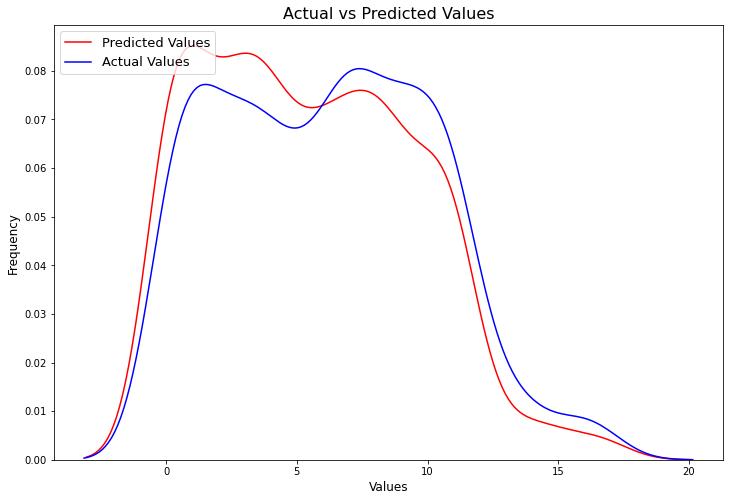

In [63]:
plt.rcParams['figure.figsize'] = [12, 8]
sns.distplot(y_pred_knn, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(Y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)


In [64]:
#some evaluation metrics, all seems good, R2 value is higher than linear regression model 
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, y_pred_knn))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, y_pred_knn))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred_knn)))
print('R-squared:', r2_score(Y_test, y_pred_knn))

Mean Absolute Error: 1.4954853273137698
Mean Squared Error: 8.50451467268623
Root Mean Squared Error: 2.9162501046182974
R-squared: 0.48505377770647184


In [57]:
#further evaluation by cross fold evaluation 
#TimeSeriesSplit used to ensure data order is correct 
tscv = TimeSeriesSplit(n_splits=5)
RMSE = []
for train_index, test_index in tscv.split(X_stand):
    print("training set length:", len(train_index), "testing set length length:", len(test_index))

    X_CV_train, X_CV_test = X_stand.iloc[train_index], X_stand.iloc[test_index]
    Y_CV_train, Y_CV_test = y.iloc[train_index], y.iloc[test_index]
    
    
    knnmodel.fit(X_CV_train,Y_CV_train)
    predicted_y = knnmodel.predict(X_CV_test)
    
    RMSE_val = np.sqrt(metrics.mean_squared_error(Y_CV_test, predicted_y))

    print('Mean Absolute Error:', metrics.mean_absolute_error(Y_CV_test, predicted_y))
    print('Mean Squared Error:', metrics.mean_squared_error(Y_CV_test, predicted_y))
    print('Root Mean Squared Error:', RMSE_val, '\n')

    RMSE.append(RMSE_val)
    
average_RMSE_val= np.mean(RMSE)
print("Average RMSE value:", average_RMSE_val)

training set length: 492 testing set length length: 492
Mean Absolute Error: 4.979674796747967
Mean Squared Error: 39.21138211382114
Root Mean Squared Error: 6.261899241749354 

training set length: 984 testing set length length: 492
Mean Absolute Error: 3.839430894308943
Mean Squared Error: 21.367886178861788
Root Mean Squared Error: 4.622541095421628 

training set length: 1476 testing set length length: 492
Mean Absolute Error: 5.815040650406504
Mean Squared Error: 49.579268292682926
Root Mean Squared Error: 7.041254738516632 

training set length: 1968 testing set length length: 492
Mean Absolute Error: 5.2317073170731705
Mean Squared Error: 38.207317073170735
Root Mean Squared Error: 6.181206765120443 

training set length: 2460 testing set length length: 492
Mean Absolute Error: 4.644308943089431
Mean Squared Error: 34.47357723577236
Root Mean Squared Error: 5.871420376346116 

Average RMSE value: 5.995664443430835


In [26]:
#prediciton example
#three continuos variables
prediction_array = [(5-scaled['temp'][0])/scaled['temp'][1], (50 - scaled['humidity'][0])/scaled['humidity'][1],
                    (5 - scaled['wind_speed'][0])/scaled['wind_speed'][1]]

#categorical variables
main = (0,0,0,0,1,0,0)
hour = (0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0)
day = (0,0,0,0,1,0,0)

prediction_array.extend(main)
prediction_array.extend(hour)
prediction_array.extend(day)


predicted_availability = knnmodel.predict([prediction_array])
predicted_availability

array([4])